# Correlation plots

In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
#import covid19_inference as cov19
from header_plotting import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

countries = ["England","Scotland","Germany","France","Spain","Slovakia","Portugal","Netherlands","Italy","Czechia","Belgium","Austria"]
traces, models, dls = [], [], []
for country in tqdm(countries):
    #'UEFA-beta=False-country=England-offset_games=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.0-tune=200-draws=300-max_treedepth=10.pickled'
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.2"+
        f"-uc=True"
        f"-len=normal"+                    
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(fstr(tune, draws, max_treedepth), " not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/12 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 8000 sample runs for Scotland
Use 8000 sample runs for Germany
Use 4000 sample runs for France
Use 8000 sample runs for Spain
Use 8000 sample runs for Slovakia
Use 4000 sample runs for Portugal
Use 8000 sample runs for Netherlands
Use 8000 sample runs for Italy
Use 8000 sample runs for Czechia
Use 8000 sample runs for Belgium
Use 8000 sample runs for Austria


In [4]:
infections_no = []
infections_primary = []
infections_secondary = []
for i, country in tqdm(enumerate(countries)):
    trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_data/primary_and_subsequent/{country}.pkl")
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    x = pd.date_range(models[i].sim_begin, models[i].sim_end)
    y0 = trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4])
    y1 = trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y0
    y2 = traces[i].posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y1 - y0

    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - model.sim_begin).days
    i_end = (end - model.sim_begin).days + 1  # inclusiv last day

    y0 = np.sum(y0[..., i_begin:i_end, :], axis=-2)
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=-2)
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=-2)

    infections_no.append(y0)
    infections_primary.append(y1)
    infections_secondary.append(y2)

0it [00:00, ?it/s]

In [5]:
data_primary  = pd.DataFrame()
means = []
for i,country in enumerate(countries):
    # compute fraction of infected people
    t_numpy = infections_primary[i] / (infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary = pd.concat([data_primary, temp])
    means.append(np.mean(temp["percentage_primary"]))
country_order_primar = np.argsort(means)[::-1]

data_primary_and_subsequent = pd.DataFrame()
means = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = (infections_primary[i]+infections_secondary[i])/(infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary_and_subsequent", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary_and_subsequent = pd.concat([data_primary_and_subsequent, temp])
    means.append(np.mean(temp["percentage_primary_and_subsequent"]))
country_order_primary_and_subsequent = np.argsort(means)[::-1]

In [10]:
# Compute interesting values as fraction and as incidence
primary_frac = []
for i, country in enumerate(countries):
    temp = data_primary[data_primary["country"] == country].drop(columns=["country","gender"])
    primary_frac.append(temp.to_numpy()[:,0])


primary_and_subsequent_frac = []
for i, country in enumerate(countries):
    temp = data_primary_and_subsequent[data_primary_and_subsequent["country"] == country].drop(columns=["country","gender"])
    primary_and_subsequent_frac.append(temp.to_numpy()[:,0])


primary_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i]
    primary_inci.append(temp.sum(axis=1) / dls[i].population.sum()*1e6)

primary_and_subsequent_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i] + infections_secondary[i]
    primary_and_subsequent_inci.append(temp.sum(axis=1) / dls[i].population.sum()*1e6)
    


In [254]:
from sklearn.linear_model import LinearRegression

def plot_corr(ax,x,y,ci_axis_x=None,ci_axis_y=None, linearRegression=True, pvalue=True):
    """ Creates correlation plot for two variables x and y

        Parameters
        ----------
        ax : matplotlib.axes.Axes
            Axes object to plot on
        x : np.ndarray
            Array of x values
        y : np.ndarray
            Array of y values
        ci_axis : int
    """
    # Compute mean and ci
    
    # compute ci
    if ci_axis_y is not None:
        y_mean = [np.mean(yi,axis=ci_axis_y) for yi in y]
        y_p025 = [np.percentile(yi, 2.5,axis=ci_axis_y) for yi in y]
        y_p975 = [np.percentile(yi,97.5,axis=ci_axis_y) for yi in y]
    else:
        y_mean = y
        y_p025 = None
        y_p975 = None
    
    if ci_axis_x is not None:
        x_mean = [np.mean(xi,axis=ci_axis_x) for xi in x]
        x_p025 = [np.percentile(xi, 2.5,axis=ci_axis_x) for xi in x]
        x_p975 = [np.percentile(xi,97.5,axis=ci_axis_x) for xi in x]
    else:
        x_mean = x
        x_p025 = None
        x_p975 = None


    if y_p025 is not None and y_p975 is not None:
        # Plot error bars
        lines = ax.vlines(
            x=x_mean,
            ymin=y_p025,
            ymax=y_p975,
            lw=2,
            zorder=9,
            color="#060434",
        )
        lines.set_capstyle("round")

    if x_p025 is not None and x_p975 is not None:
        # Plot error bars
        lines = ax.hlines(
            y=y_mean,
            xmin=x_p025,
            xmax=x_p975,
            lw=2,
            zorder=9,
            color="#060434",
        )
        lines.set_capstyle("round")

    ax.scatter(
        x=x_mean,
        y=y_mean,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )

    if linearRegression:
        models = []
        n_bootstrap = 10000
        for i in range(n_bootstrap):
            samples_x = []
            samples_y = []
            for country in range(len(x_mean)):
                # Draw random sample
                if ci_axis_x is not None:
                    x_sample = np.random.choice(x[country], size=1, replace=True)[0]
                else:
                    x_sample = x[country]
                if ci_axis_y is not None:
                    y_sample = np.random.choice(y[country], size=1, replace=True)[0]
                else:
                    y_sample = y[country]
                samples_x.append(x_sample)
                samples_y.append(y_sample)
            samples_x = np.array(samples_x)
            samples_y = np.array(samples_y)
            
            # Fit model
            models.append(LinearRegression().fit(samples_x.reshape(-1, 1), samples_y.reshape(-1, 1)))

        
        # Plot models
        x_plot = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 1000)
        y_plot = []
        for model in models:
            y_plot.append(model.predict(x_plot.reshape(-1,1)))
        y_plot = np.array(y_plot)[:,:,0]
        # Compute mean and ci
        mean_mod = y_plot.mean(axis=0)
        p025_mod = np.percentile(y_plot, 2.5,axis=0)
        p975_mod = np.percentile(y_plot,97.5,axis=0)

        ax.plot(x_plot,mean_mod,color="#009988",lw=1)
        ax.fill_between(x_plot,p025_mod,p975_mod,color="#009988",alpha=0.2)

        if pvalue:

            # Calculate p-value
            bigger = []
            for model in models:
                bigger.append(model.coef_[0] > 0)
            p_val = np.sum(bigger) / n_bootstrap
            
            # Plot
            ax.text(
                x=ax.get_xlim()[0]+ax.get_xlim()[1]*0.005,
                y=ax.get_ylim()[0]+ax.get_ylim()[1]*0.05,
                s=f"$P(a>0)= {p_val:.3f}$",
                fontsize=8,
            )


## Correlation between NPIs stringency pre EURO2020 and effect size
Creates a correlation plot between the non-pharmacutical interventions (NPIs) stringency as tracked by the Oxford Stringency Index and the primary and secondary soccer related effect.

In [12]:
# Load stringency index
from covid19_inference import data_retrieval as cov19dat

stringency = cov19dat.OxCGRT(True)

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


In [235]:
meanStringencyPreEuro2020 = []
for i, country in enumerate(countries):
    if country == "Slovakia":
        country = "Slovak Republic"
    if country == "Czechia":
        country = "Czech Republic"
    if country in ["England","Scotland"]:
        SindexCountry = stringency.data[stringency.data["RegionName"] == country]["StringencyIndex"][begin-datetime.timedelta(days=14):begin]
    else:
        SindexCountry = stringency.data[stringency.data["country"] == country]["StringencyIndex"][begin-datetime.timedelta(days=14):begin]

    meanStringencyPreEuro2020.append(SindexCountry.mean())

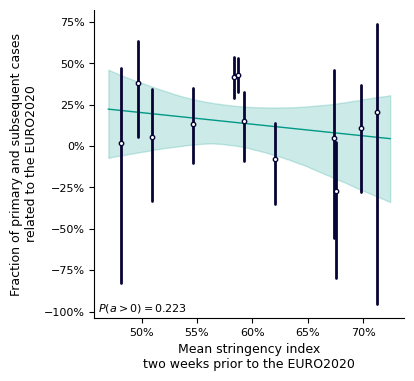

In [255]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

plot_corr(ax,meanStringencyPreEuro2020,primary_and_subsequent_frac,ci_axis_y=0)
ax.set_ylabel("Fraction of primary and subsequent cases\nrelated to the EURO2020")
ax.set_xlabel("Mean stringency index\ntwo weeks prior to the EURO2020")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(100,0))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(100,0))
plt.show()

fig.savefig(f"../figures/correlation_NPIstringency.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation_NPIstringency.png", **save_kwargs)
plt.close(fig=fig)

## Correlation between Mobility during EURO2020 and effect size

Creates a correlation plot between google mobility index and the primary and secondary soccer related effect.

In [9]:
mobility = cov19dat.GOOGLE(True)
df = mobility.data
df = df.reset_index()



INFO     [covid19_inference.data_retrieval.retrieval] Successfully downloaded Google.csv.gz to /tmp/covid19_data/.
INFO     [covid19_inference.data_retrieval.retrieval] Local backup to /tmp/covid19_data/Google.csv.gz successful.


In [15]:
city2country = {
    'Aberdeen City': 'Scotland',
    'Aberdeenshire': 'Scotland',
    'Angus Council': 'Scotland',
    'Antrim and Newtownabbey': 'Northern Ireland',
    'Ards and North Down': 'Northern Ireland',
    'Argyll and Bute Council': 'Scotland',
    'Armagh City, Banbridge and Craigavon': 'Northern Ireland',
    'Bath and North East Somerset': 'England',
    'Bedford': 'England',
    'Belfast': 'Northern Ireland',
    'Blackburn with Darwen': 'England',
    'Blackpool': 'England',
    'Blaenau Gwent': 'Wales',
    'Borough of Halton': 'England',
    'Bracknell Forest': 'England',
    'Bridgend County Borough': 'Wales',
    'Brighton and Hove': 'England',
    'Bristol City': 'England',
    'Buckinghamshire': 'England', 
    'Caerphilly County Borough': 'Wales',
    'Cambridgeshire': 'England', 
    'Cardiff': 'Wales',
    'Carmarthenshire': 'Wales', 
    'Causeway Coast and Glens': 'England',
    'Central Bedfordshire': 'England',
    'Ceredigion': 'Wales',
    'Cheshire East': 'England',
    'Cheshire West and Chester': 'England',
    'Clackmannanshire': 'Scotland',
    'Conwy Principal Area': 'Wales',
    'Cornwall': 'England',
    'County Durham': 'England',
    'Cumbria': 'England',
    'Darlington': 'England',
    'Denbighshire': 'Wales',
    'Derby': 'England',
    'Derbyshire': 'England',
    'Derry and Strabane': 'Northern Ireland',
    'Devon': 'England',
    'Dorset': 'England',
    'Dumfries and Galloway': 'Scotland',
    'Dundee City Council': 'Scotland',
    'East Ayrshire Council': 'Scotland',
    'East Dunbartonshire Council': 'Scotland',
    'East Lothian Council': 'Scotland',
    'East Renfrewshire Council': 'Scotland',
    'East Riding of Yorkshire': 'England',
    'East Sussex': 'England',
    'Edinburgh': 'Scotland',
    'Essex': 'England',
    'Falkirk': 'Scotland',
    'Fermanagh and Omagh': 'Northern Ireland',
    'Fife': 'Scotland',
    'Flintshire': 'Wales',
    'Glasgow City': 'Scotland',
    'Gloucestershire': 'England',
    'Greater London': 'England',
    'Greater Manchester': 'England',
    'Gwynedd': 'Wales',
    'Hampshire': 'England',
    'Hartlepool': 'England',
    'Herefordshire': 'England',
    'Hertfordshire': 'England',
    'Highland Council': 'Scotland',
    'Inverclyde': 'Scotland',
    'Isle of Anglesey': 'Wales',
    'Isle of Wight': 'England',
    'Kent': 'England',
    'Kingston upon Hull': 'England',
    'Lancashire': 'England',
    'Leicester': 'England',
    'Leicestershire': 'England',
    'Lincolnshire': 'England',
    'Lisburn and Castlereagh': 'Northern Ireland',
    'Luton': 'England',
    'Medway': 'England',
    'Merseyside': 'England',
    'Merthyr Tydfil County Borough': 'Wales',
    'Mid and East Antrim': 'Northern Ireland',
    'Mid Ulster': 'Northern Ireland',
    'Middlesbrough': 'England',
    'Midlothian': 'Scotland',
    'Milton Keynes':  'England',
    'Monmouthshire': 'Wales',
    'Moray': 'Scotland',
    'Na h-Eileanan an Iar': 'Scotland',
    'Neath Port Talbot Principle Area': 'Wales',
    'Newport': 'Wales',
    'Newry, Mourne and Down': 'Northern Ireland',
    'Norfolk': 'England',
    'North Ayrshire Council': 'Scotland',
    'North East Lincolnshire': 'England',
    'North Lanarkshire': 'Scotland',
    'North Lincolnshire': 'England',
    'North Somerset': 'England',
    'North Yorkshire': 'England',
    'Northamptonshire': 'England',
    'Northumberland': 'England',
    'Nottingham': 'England',
    'Nottinghamshire': 'England',
    'Orkney': 'Scotland',
    'Oxfordshire': 'England',
    'Pembrokeshire': 'Wales',   
    'Perth and Kinross': 'Scotland',
    'Peterborough': 'England',
    'Plymouth': 'England',
    'Portsmouth': 'England',
    'Powys': 'Wales',
    'Reading': 'England',
    'Redcar and Cleveland': 'England',
    'Renfrewshire': 'Scotland',
    'Rhondda Cynon Taff': 'Wales',
    'Rutland': 'England',
    'Scottish Borders': 'Scotland',
    'Shetland Islands': 'Scotland',
    'Shropshire': 'England',
    'Slough': 'England',
    'Somerset': 'England',
    'South Ayrshire Council': 'Scotland',
    'South Gloucestershire': 'England',
    'South Lanarkshire': 'Scotland',
    'South Yorkshire': 'England',
    'Southampton': 'England',
    'Southend-on-Sea': 'England',
    'Staffordshire': 'England',
    'Stirling': 'Scotland',
    'Stockton-on-Tees': 'England',
    'Stoke-on-Trent': 'England',
    'Suffolk': 'England',
    'Surrey': 'England',
    'Swansea': 'Wales',
    'Swindon': 'England',
    'Thurrock': 'England',
    'Torbay': 'England',
    'Torfaen Principal Area': 'Wales',
    'Tyne and Wear': 'England',
    'Vale of Glamorgan': 'Wales',
    'Warrington': 'England',
    'Warwickshire': 'England',
    'West Berkshire': 'England',
    'West Dunbartonshire Council': 'Scotland',
    'West Lothian': 'Scotland',
    'West Midlands': 'England',
    'West Sussex': 'England',
    'West Yorkshire': 'England',
    'Wiltshire': 'England',
    'Windsor and Maidenhead': 'England',
    'Wokingham': 'England',
    'Worcestershire': 'England',
    'Wrexham Principal Area': 'Wales',
    'York': 'England'
}


def apply_city_to_country(row):
    if row["state"] in city2country:
        row["country"] = city2country[row["state"]]
    return row

df[df["country"]=="United Kingdom"] = df[df["country"]=="United Kingdom"].apply(apply_city_to_country, axis=1)

In [16]:

measures = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

measure2title = {
    'retail_and_recreation_percent_change_from_baseline': 'Retail and recreation',
    'grocery_and_pharmacy_percent_change_from_baseline': 'Grocery and pharmacy',
    'parks_percent_change_from_baseline': 'Parks',
    'transit_stations_percent_change_from_baseline': 'Transit stations',
    'workplaces_percent_change_from_baseline': 'Workplaces',
    'residential_percent_change_from_baseline': 'Residential'
}

meanMobilityEuro2020 = {}
for measure in measures:
    meanMobilityEuro2020[measure] = []

for i, country in enumerate(countries):
    # Mean over all Scotland and England entries
    if country in ["Scotland","England"]:
        temp = df[df["country"]==country].groupby("date").mean()
    else:
        temp = df[df["country"]==country]
    
    if "state" in temp.columns:
        temp = temp[temp["state"].isna()]

    temp = temp.groupby("date").mean()

    for i, measure in enumerate(measures):
        meanMobilityEuro2020[measure].append(temp[measure][begin:end].to_numpy())


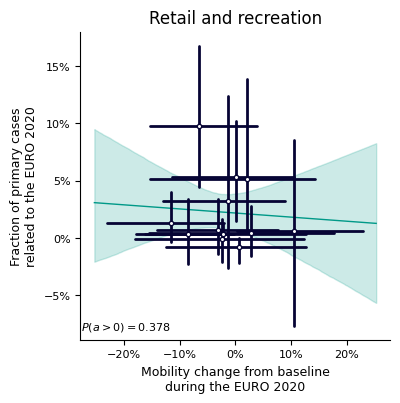

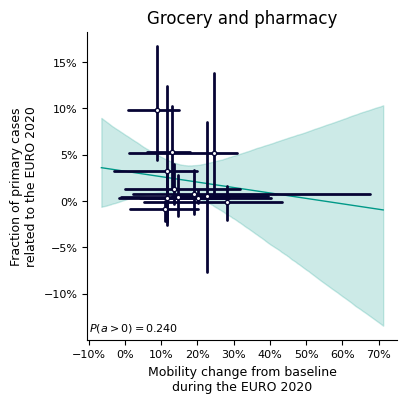

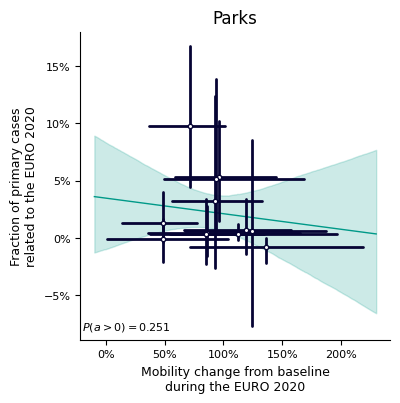

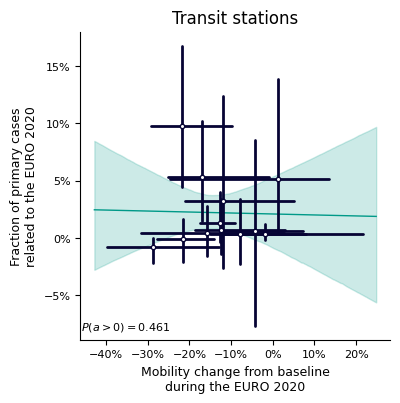

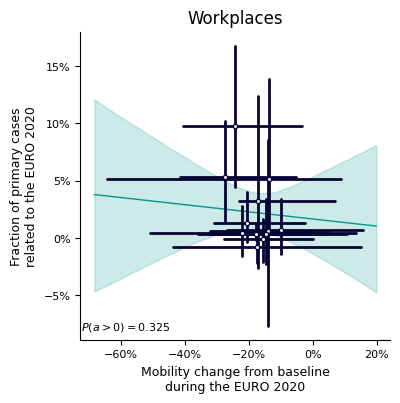

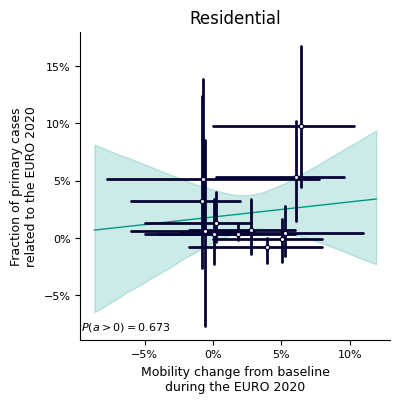

In [256]:
for measure in measures:
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    plot_corr(ax, meanMobilityEuro2020[measure], primary_frac, ci_axis_y=0, ci_axis_x=0)

    ax.set_xlabel("Mobility change from baseline\nduring the EURO 2020")
    ax.set_ylabel("Fraction of primary cases\nrelated to the EURO 2020")
    ax.set_title(measure2title[measure])
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(100,0))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(100,0))

    plt.show()
    fig.savefig(f"../figures/correlation_Mobility_{measure}.pdf", **save_kwargs)
    fig.savefig(f"../figures/correlation_Mobility_{measure}.png", **save_kwargs)
    plt.close(fig=fig)

## Correlation between Reproduction number pre EURO2020 and effect size

Correlation plot reproduction number pre EURO2020 as inferred from our model and effect size.

In [18]:
reproNumberPreEURO2020 = []
reproNumberPostEuro2020 = []
for i, country in enumerate(countries):
    i_begin = (begin - models[i].sim_begin).days
    R = traces[i].posterior["R_t_base"][:,:,i_begin-14:i_begin].to_numpy()
    R = R.reshape(R.shape[0]*R.shape[1]*R.shape[2])
    reproNumberPreEURO2020.append(R)

    i_end = (end - models[i].sim_begin).days
    R = traces[i].posterior["R_t_base"][:,:,i_end-14:i_end].to_numpy()
    R = R.reshape(R.shape[0]*R.shape[1]*R.shape[2])
    reproNumberPostEuro2020.append(R)


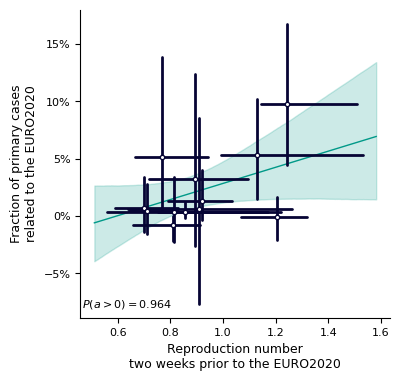

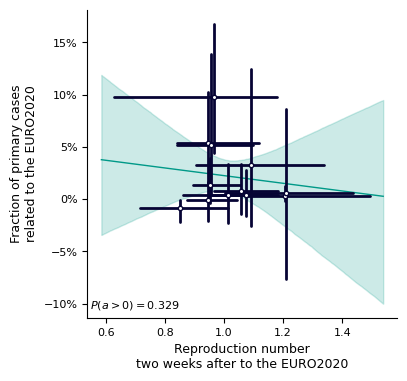

In [257]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_corr(ax, reproNumberPreEURO2020, primary_frac, ci_axis_y=0, ci_axis_x=0,)
ax.set_xlabel("Reproduction number\ntwo weeks prior to the EURO2020")
ax.set_ylabel("Fraction of primary cases\nrelated to the EURO2020")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(100,0))
plt.show()
fig.savefig(f"../figures/correlation_ReproNum_preEURO2020.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation_ReproNum_preEURO2020.png", **save_kwargs)
plt.close(fig=fig)


fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_corr(ax, reproNumberPostEuro2020, primary_frac, ci_axis_y=0, ci_axis_x=0,)
ax.set_xlabel("Reproduction number\ntwo weeks after to the EURO2020")
ax.set_ylabel("Fraction of primary cases\nrelated to the EURO2020")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(100,0))
plt.show()
fig.savefig(f"../figures/correlation_ReproNum_postEURO2020.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation_ReproNum_postEURO2020.png", **save_kwargs)
plt.close(fig=fig)


## Correlation between incidence pre EURO2020 and effect size

In [19]:
jhu = cov19dat.JHU(True)


incedencePreEuro2020 = []
for i, country in enumerate(countries):
    temp = pd.DataFrame()
    temp_m = dls[i]._cases.loc[
        begin - datetime.timedelta(days=21) : begin,
        "male",
        "total",
    ]
    temp_f = dls[i]._cases.loc[
        begin - datetime.timedelta(days=21) : begin,
        "female",
        "total",
    ]

    # Reshape to date, gender and male at the front
    t =  np.stack((temp_m.to_numpy(), temp_f.to_numpy()), axis=1)
    incidence = t.sum(axis=(1,2)) / dls[i].population.sum()*1e6
    incedencePreEuro2020.append(incidence.mean())
    

INFO     [covid19_inference.data_retrieval._JHU] Successfully downloaded new files.
INFO     [covid19_inference.data_retrieval._JHU] Local backup to ['/tmp/covid19_data/Jhu_confirmed.csv.gz', '/tmp/covid19_data/Jhu_deaths.csv.gz', '/tmp/covid19_data/Jhu_recovered.csv.gz'] successful.


In [20]:
incidenceRelatedToEuro2020 = []
for i, country in enumerate(countries):
    temp = infections_primary[i]+infections_secondary[i]
    incidenceRelatedToEuro2020.append(temp.sum(axis=1) / dls[i].population.sum()*1e6)

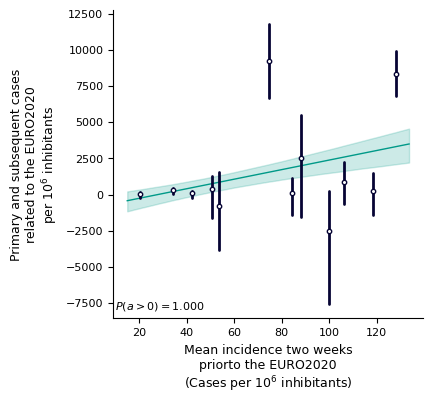

In [258]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

plot_corr(ax,incedencePreEuro2020,incidenceRelatedToEuro2020,ci_axis_y=0,)
ax.set_ylabel("Primary and subsequent cases\nrelated to the EURO2020\nper $10^6$ inhibitants")
ax.set_xlabel("Mean incidence two weeks\npriorto the EURO2020\n(Cases per $10^6$ inhibitants)")
#ax.yaxis.set_major_formatter(ticker.PercentFormatter(100,0))

plt.show()
fig.savefig(f"../figures/correlation_incidence.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation_incidence.png", **save_kwargs)
plt.close(fig=fig)

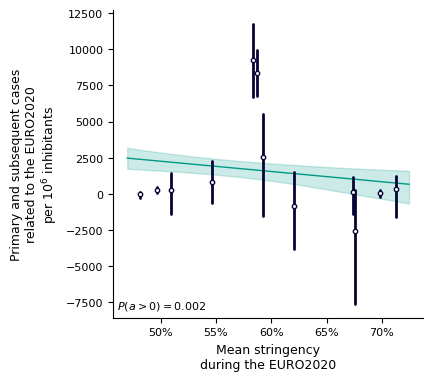

In [260]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_corr(ax, meanStringencyPreEuro2020, incidenceRelatedToEuro2020, ci_axis_y=0,)
ax.set_xlabel("Mean stringency\nduring the EURO2020")
ax.set_ylabel("Primary and subsequent cases\nrelated to the EURO2020\nper $10^6$ inhibitants")
ax.xaxis.set_major_formatter(ticker.PercentFormatter(100,0))
plt.show()
fig.savefig(f"../figures/correlation_NPIs_incidence.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation_NPIs_incidence.png", **save_kwargs)
plt.close(fig=fig)


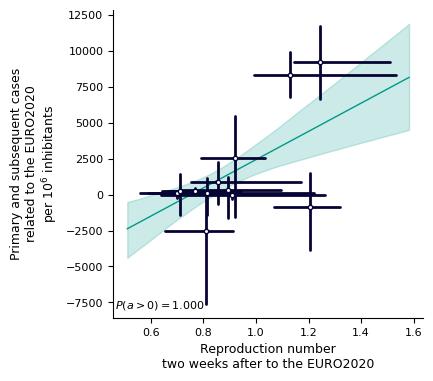

In [261]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_corr(ax, reproNumberPreEURO2020, incidenceRelatedToEuro2020, ci_axis_y=0, ci_axis_x=0,)
ax.set_xlabel("Reproduction number\ntwo weeks after to the EURO2020")
ax.set_ylabel("Primary and subsequent cases\nrelated to the EURO2020\nper $10^6$ inhibitants")
#ax.yaxis.set_major_formatter(ticker.PercentFormatter(100,0))
plt.show()
fig.savefig(f"../figures/correlation_ReproNum_incidence.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation_ReproNum_incidence.png", **save_kwargs)
plt.close(fig=fig)


## Google trends

In [ ]:
# TODO

## Overview

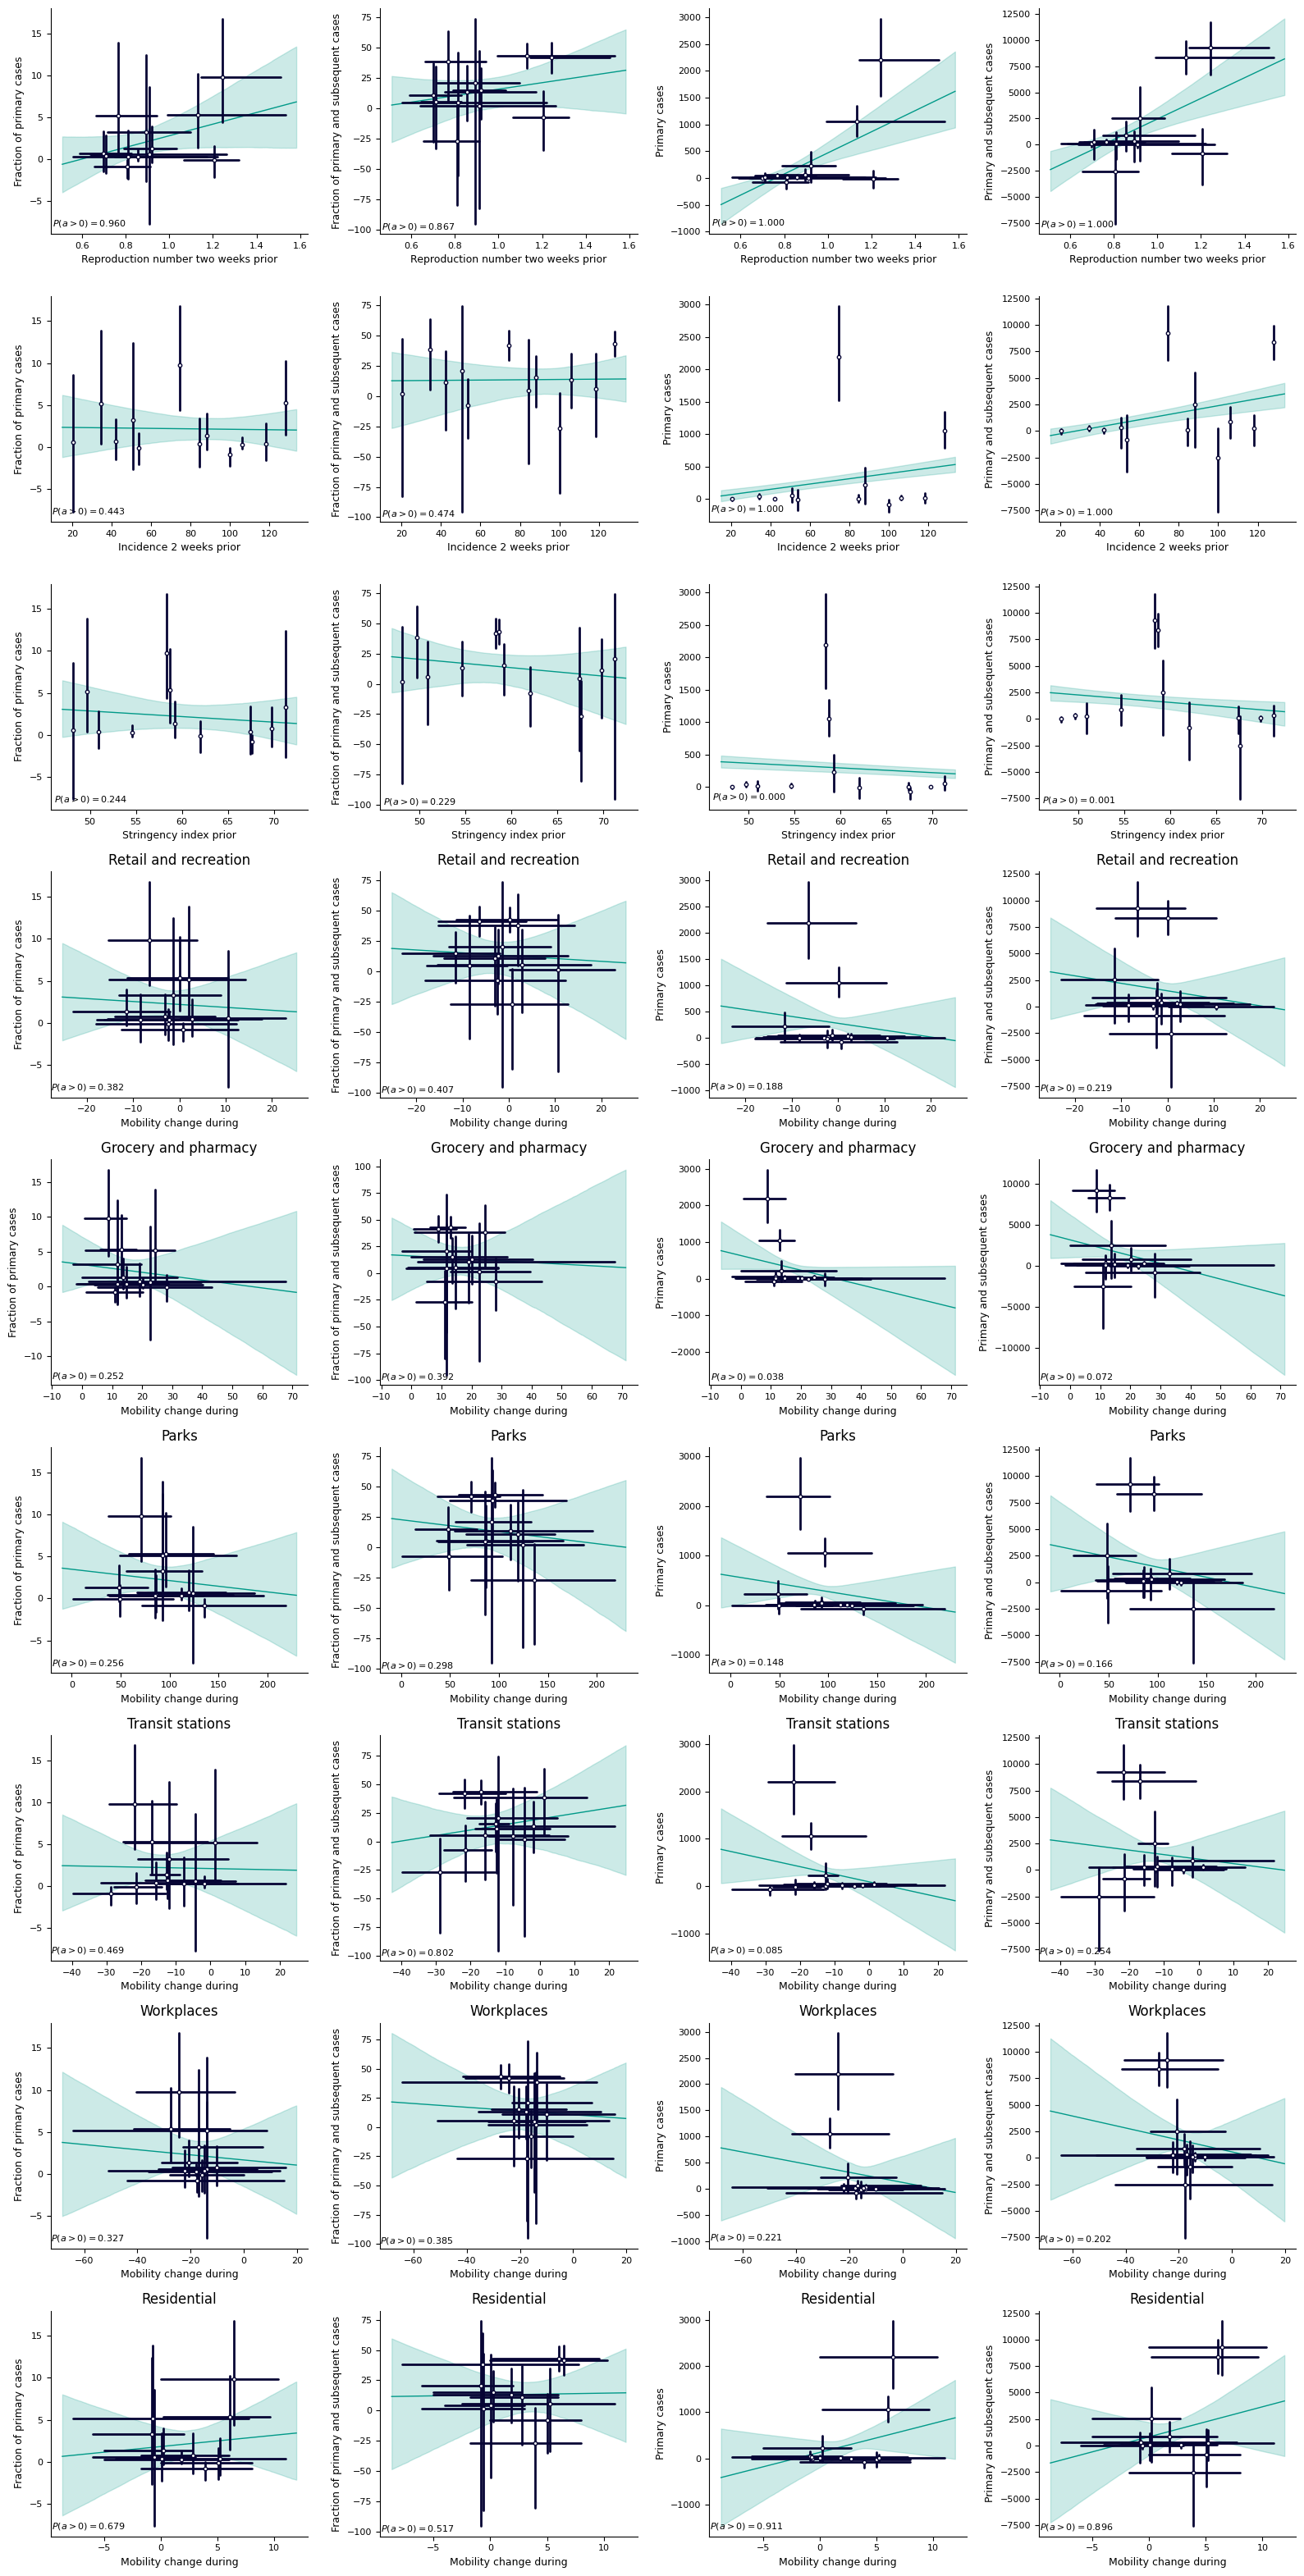

In [262]:
## Big overview plot
# - reproNumberPreEURO2020 vs primary cases | primary & subsequent cases | primary fraction | primary & subsequent fraction

columns = [primary_frac, primary_and_subsequent_frac, primary_inci, primary_and_subsequent_inci]
col_labels = ["Fraction of primary cases", "Fraction of primary and subsequent cases", "Primary cases", "Primary and subsequent cases"]
rows = [reproNumberPreEURO2020, incedencePreEuro2020, meanStringencyPreEuro2020]
row_labels = ["Reproduction number two weeks prior", "Incidence 2 weeks prior", "Stringency index prior"]
# Add mobility
for measure in measures:
    rows.append(meanMobilityEuro2020[measure])
    row_labels.append("Mobility change during")

fig, axes = plt.subplots(len(rows),len(columns),figsize=(4*len(columns),3.5*len(rows)))

for j, r in enumerate(rows):
    for i, c in enumerate(columns):
        if j in [1,2]:
            plot_corr(axes[j,i], r, c, ci_axis_y=0)
        else:
            plot_corr(axes[j,i], r, c, ci_axis_y=0, ci_axis_x=0,)

        axes[j,i].set_ylabel(col_labels[i])
        axes[j,i].set_xlabel(row_labels[j])

        # Set title for mobility plots
        if j > 2:
            axes[j,i].set_title(measure2title[measures[j-3]])



plt.tight_layout()
plt.show()
fig.savefig(f"../figures/correlation_overview.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation_overview.png", **save_kwargs)
plt.close(fig=fig)


## Multivariate analysis


TODO: Cleanup 


In [297]:
import pymc3 as pm
from sklearn.preprocessing import StandardScaler


# Pick n samples from each dimension
n = 10000 // 12
data = pd.DataFrame()
Y = []
X = []


weights = []
for i, country in enumerate(countries):
    weights_c = []

    # Get primary fraction
    y = np.random.choice(primary_frac[i], size=n, replace=True, )

    # Get reproduction number pre
    x1 = np.random.choice(reproNumberPreEURO2020[i], size=n, replace=True, )
    w = (len(reproNumberPreEURO2020[i])/14)/n
    weights_c.append([w]*n)
    # Get incidence pre
    x2 = np.array([incedencePreEuro2020[i]]*n)
    w = 1/n
    weights_c.append([w]*n)
    # Get stringency
    x3 = np.array([meanStringencyPreEuro2020[i]]*n)
    w =1/n
    weights_c.append([w]*n)
    
    # Get mobility
    xMob = []
    for measure in measures:
        xMob.append(np.random.choice(meanMobilityEuro2020[measure][i], size=n, replace=True, ))
        w = len(meanMobilityEuro2020[measure][i])/n
        weights_c.append([w]*n)

    # Concatenate x and y
    if i == 0:
        X = np.array([x1,x2,x3,*xMob])
        weights = np.array(weights_c)
    else:
        X = np.concatenate((X, np.array([x1, x2, x3, *xMob])),axis=1)
        weights = np.concatenate((weights, np.array(weights_c)),axis=1)
    Y = np.concatenate((Y, y))

    # Compute weights by number of samples


# Normalize x to be between 0 and 1
#scalerX = StandardScaler()
#X = scalerX.fit_transform(X)
#scalerY = StandardScaler()
#Y = scalerY.fit_transform(Y.reshape(-1,1))[:,0]


In [298]:
# Define model
# Y = beta*X + intercept
with pm.Model() as model:
    # Priors
    sigma = pm.HalfCauchy("sigma", beta=3)
    beta = pm.Normal('mu', mu=0, sd=3,shape=X.shape[0])
    intercept = pm.Normal('intercept', mu=0, sd=3,shape=1)

    # Likelihood
    likelihood = pm.Normal('y', mu=intercept+X.T@beta, sd=np.std(Y)+sigma, observed=Y)

    # Inference
    trace = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, mu, sigma]
INFO     [pymc3] NUTS: [intercept, mu, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 90 seconds.
INFO     [pymc3] Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 90 seconds.


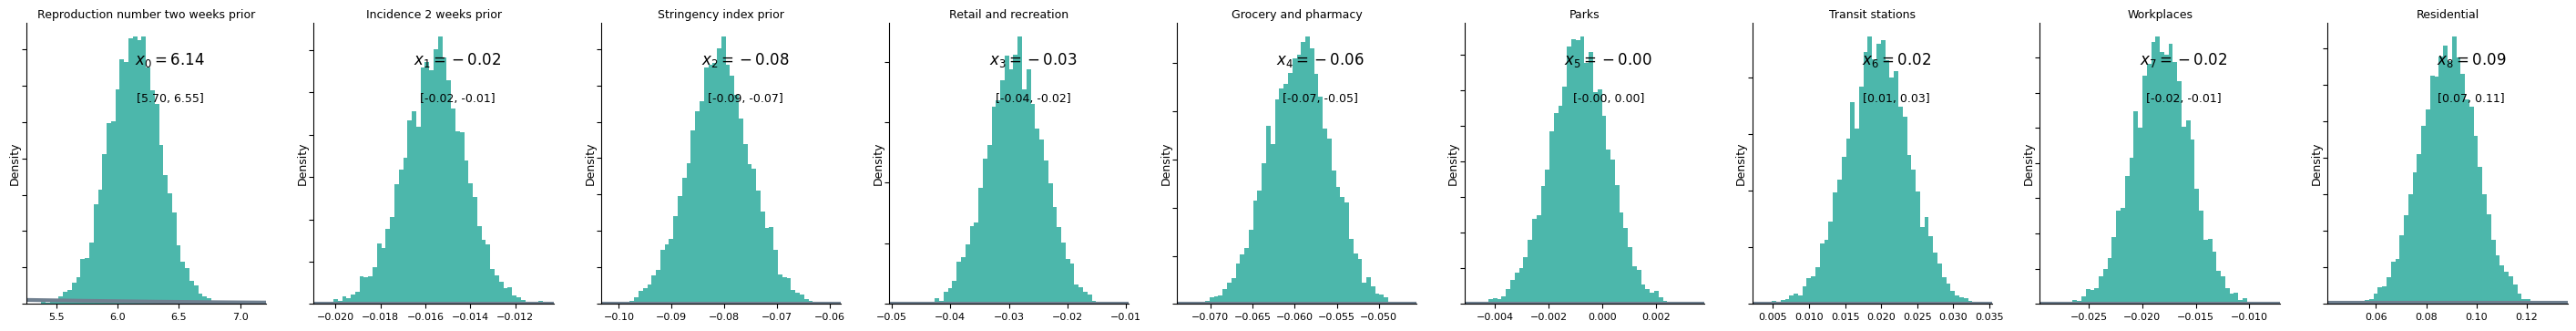

In [299]:
import arviz as az

# Plot mu
axes = covid19_soccer.plot.distribution(model,trace,key="mu")
for i, ax in enumerate(axes):
    ax.set_ylabel("Density")

    ax.set_xlabel(row_labels[i])
    if i > 2:
        ax.set_xlabel(measure2title[measures[i-3]])
plt.show()

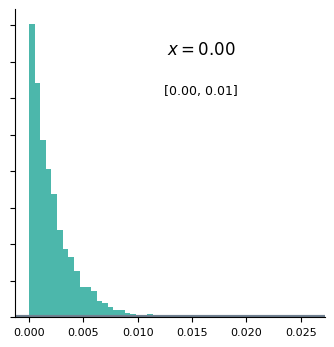

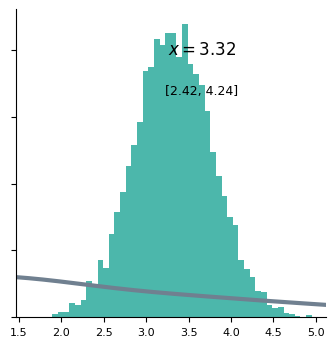

In [302]:
covid19_soccer.plot.distribution(model,trace,key="sigma")
covid19_soccer.plot.distribution(model,trace,key="intercept")
plt.show()

In [269]:
import seaborn as sns

# Compute the correlation matrix
corr = np.corrcoef(weights*X)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, cmap=cmap, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Set axis labels
labels = []
for i in range(len(row_labels)):
    labels.append(row_labels[i])
    if i > 2:
        labels[i] = "Mobility: "+measure2title[measures[i-3]]
ax.set_xticklabels(labels, rotation=90, fontsize=8)
ax.set_yticklabels(labels, rotation=0, fontsize=8);

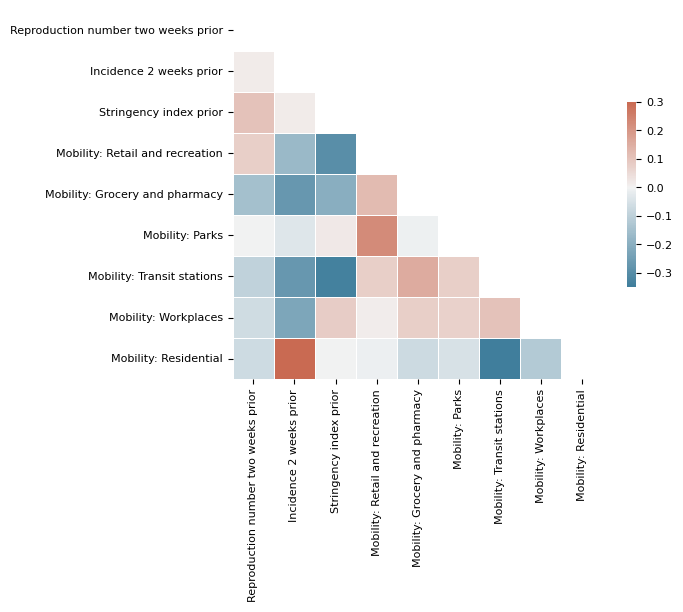

In [270]:
plt.show()

In [272]:
a = 5